In [4]:
import Pkg
# Pkg.add("Optim")
# Pkg.add("Plots")
# Pkg.add("NLopt")

In [5]:
using LinearAlgebra
using NLopt
using Plots

function gpr_predict(xB::Vector{Float64}, yB::Vector{Float64}; xPred=nothing, plot_result=true)

    # Função objetivo (log-verossimilhança negativa)
    function objective(x::Vector, grad::Vector)
        c2, c1, c0, sigmaF2, ell, sigmaN2, c4, c3 = x
        mxB = c4 .* xB.^4 .+ c3 .* xB.^3 .+ c2 .* xB.^2 .+ c1 .* xB .+ c0
        n = length(xB)
        KB = zeros(n, n)
        for i in 1:n
            for j in i:n
                noise = (i == j) ? sigmaN2^2 : 0.0
                k = sigmaF2^2 * exp(-((xB[i] - xB[j])^2) / (2 * ell^2)) + noise
                KB[i,j] = k
                KB[j,i] = k
            end
        end
        # Estabilidade numérica: checa Cholesky
        try
            cholesky(Symmetric(KB))
        catch
            return 1e10
        end
        KBinv = inv(KB)
        diff = yB .- mxB
        term1 = -0.5 * logdet(KB)
        term2 = -0.5 * (diff' * KBinv * diff)[1]
        term3 = -n/2 * log(2π)
        return -(term1 + term2 + term3)
    end

    # Configura o otimizador COBYLA
    opt = Opt(:LN_COBYLA, 8)
    lower_bounds!(opt, [-10.0, -10.0, -10.0, 0.8, 1.0, 1e-5, -10.0, -10.0])
    upper_bounds!(opt, [ 10.0,  10.0,  10.0, 5.0, 5.0, 1.0,   10.0,  10.0])
    xtol_rel!(opt, 1e-6)
    maxeval!(opt, 2000)
    min_objective!(opt, objective)

    # Valores iniciais (idênticos ao Python)
    x0 = [0.1, 0.01, 0.01, 2.0, 1.0, 0.01, 0.01, 0.01]

    # Executa otimização
    minf, xopt, ret = NLopt.optimize(opt, x0)

    # Hiperparâmetros aprendidos
    c2, c1, c0, sigmaF2, ell, sigmaN2, c4, c3 = xopt

    # Funções de média e covariância
    priormean(x) = c4 .* x.^4 .+ c3 .* x.^3 .+ c2 .* x.^2 .+ c1 .* x .+ c0
    corrFunc(xa, xb) = sigmaF2^2 * exp(-((xa - xb)^2) / (2 * ell^2))

    # Domínio de predição
    if xPred === nothing
        xPred = 0:0.2:10
    end

    nB = length(xB)
    nPred = length(xPred)

    # Matriz KB (covariância dos dados)
    KB = zeros(nB, nB)
    for i in 1:nB
        for j in i:nB
            noise = (i == j) ? sigmaN2^2 : 0.0
            k = corrFunc(xB[i], xB[j]) + noise
            KB[i,j] = k
            KB[j,i] = k
        end
    end
    KBinv = inv(KB)

    # Ks: covariância entre predição e treino
    Ks = [corrFunc(xp, xb) for xp in xPred, xb in xB]

    # Kss: covariância entre pontos de predição
    Kss = [corrFunc(xi, xj) + (i == j ? sigmaN2^2 : 0.0)
           for (i, xi) in enumerate(xPred), (j, xj) in enumerate(xPred)]

    # Média e variância preditiva
    mxB = priormean(xB)
    mus = priormean(xPred)
    ypred = mus + Ks * KBinv * (yB - mxB)
    yvar = diag(Kss - Ks * KBinv * Ks')
    stds = sqrt.(max.(yvar, 0.0))

    # Plot semelhante ao Python
    if plot_result
        x = 0:0.1:10
        mx = priormean(x)
        plt = plot(x, mx, label="mean m(x)", lw=2, legend=:topright)
        scatter!(xB, yB, label="training data", color=:red)
        plot!(xPred, ypred, linestyle=:dash, color=:green, label="predictions")
        plot!(xPred, ypred, ribbon=2*stds, fillalpha=0.3, label="95% CI", color=:green)
        xlabel!("x")
        ylabel!("f(x)")
        title!("Gaussian Process Prediction with Bi-quadratic Mean")
        default(grid = true)
        display(plt)
    end

    return xPred, ypred, stds
end


gpr_predict (generic function with 1 method)

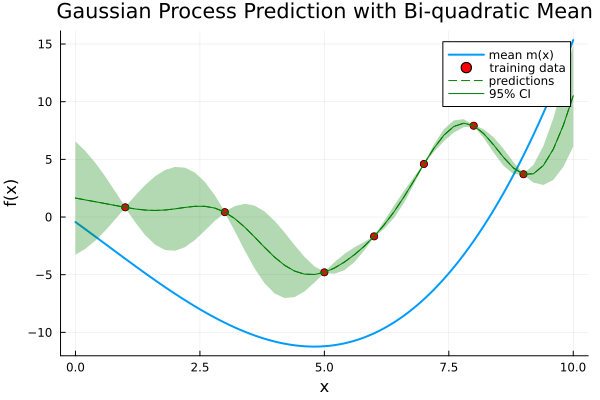

(0.0:0.2:10.0, [1.6459557516662626, 1.481728108423786, 1.3252839588616534, 1.1663798177206552, 1.002459451026592, 0.8413539688460232, 0.7007267272681084, 0.6035467075776415, 0.5701583304200275, 0.6089057916149567  …  7.237586496029013, 6.251416176895295, 5.170968188018736, 4.244647758965836, 3.7094835014753587, 3.750198477998297, 4.471730396250052, 5.890640154766566, 7.945258141466956, 10.519533004688732], [2.4549315462987296, 2.116171581072484, 1.684687837708469, 1.170567259782061, 0.59749301483463, 0.026369015053736997, 0.5771346456207425, 1.0861327407359844, 1.4841197523497052, 1.7353927159981748  …  0.19032635255369193, 0.3308376112340485, 0.36582969582973396, 0.25834588047164975, 0.026368787758702807, 0.38400749964187075, 0.8469750680662379, 1.3363459492902527, 1.800831337586902, 2.2024024904931703])

In [6]:
xB = [1., 3., 5., 6., 7., 8., 9.]
yB = xB .* sin.(xB)

xPred, yPred, stds = gpr_predict(xB, yB; plot_result=true)

In [7]:
using LinearAlgebra
using Statistics
using Optim
using Plots

function gpr_predict_multidim(XB, yB; XPred=nothing, plot_result=true)
    XB = reshape(XB, :, size(XB, ndims(XB)))  # garantir 2D
    n_samples, n_features = size(XB)

    # Normalização de entrada
    X_mean = mean(XB, dims=1)
    X_std = std(XB, dims=1)
    XB_scaled = (XB .- X_mean) ./ X_std

    # Centralizar saída
    y_mean = mean(yB)
    y_centered = yB .- y_mean

    # Normalizar XPred
    if XPred !== nothing
        XPred = reshape(XPred, :, size(XPred, ndims(XPred)))
        XPred_scaled = (XPred .- X_mean) ./ X_std
    else
        x1 = range(-2, 2, length=50)
        x2 = range(-2, 2, length=50)
        Xgrid = [[x1[i], x2[j]] for j in 1:50, i in 1:50]
        XPred_scaled = reduce(vcat, Xgrid)
    end

    # Média linear + constante
    priormean(Xin, w, b) = Xin * w .+ b

    # Kernel RBF
    function corrFunc(xa, xb, sigmaF2, ell)
        d = sum((xa .- xb).^2)
        return sigmaF2^2 * exp(-d / (2 * ell^2))
    end

    # Função objetivo: log-verossimilhança negativa
    function objective(x)
        w = x[1:n_features]
        b = x[n_features + 1]
        sigmaF2 = x[n_features + 2]
        ell = x[n_features + 3]
        sigmaN2 = x[n_features + 4]
        mxB = priormean(XB_scaled, w, b)
        KB = zeros(n_samples, n_samples)
        for i in 1:n_samples
            for j in i:n_samples
                k = corrFunc(XB_scaled[i, :], XB_scaled[j, :], sigmaF2, ell)
                if i == j
                    k += sigmaN2^2 + 1e-8
                end
                KB[i, j] = KB[j, i] = k
            end
        end
        KBinv = inv(KB)
        logdetKB = log(det(KB))
        term1 = -0.5 * logdetKB
        term2 = -0.5 * (y_centered - mxB)' * KBinv * (y_centered - mxB)
        term3 = -0.5 * n_samples * log(2π)
        return -(term1 + term2 + term3)
    end

    # Restrições como penalização
    function constrained_objective(x)
        ell = x[n_features + 3]
        sigmaF2 = x[n_features + 2]
        penalty = 0.0
        penalty += ell < 1 ? 1000 * abs(1 - ell) : 0
        penalty += ell > 5 ? 1000 * abs(ell - 5) : 0
        penalty += sigmaF2 < 0.8 ? 1000 * abs(0.8 - sigmaF2) : 0
        return objective(x) + penalty
    end

    # Inicialização
    x0 = fill(0.1, n_features + 4)
    x0[n_features + 2] = 2.0   # sigmaF2
    x0[n_features + 3] = 1.0   # ell
    x0[n_features + 4] = 0.1   # sigmaN2

    result = optimize(constrained_objective, x0, NelderMead(); iterations=500)
    xopt = Optim.minimizer(result)

    # Hiperparâmetros finais
    w = xopt[1:n_features]
    b = xopt[n_features + 1]
    sigmaF2 = xopt[n_features + 2]
    ell = xopt[n_features + 3]
    sigmaN2 = xopt[n_features + 4]

    # Covariância treino
    mxB = priormean(XB_scaled, w, b)
    KB = zeros(n_samples, n_samples)
    for i in 1:n_samples
        for j in i:n_samples
            k = corrFunc(XB_scaled[i, :], XB_scaled[j, :], sigmaF2, ell)
            if i == j
                k += sigmaN2^2 + 1e-8
            end
            KB[i, j] = KB[j, i] = k
        end
    end
    KBinv = inv(KB)

    # Predição
    n_pred = size(XPred_scaled, 1)
    Ks = [corrFunc(XPred_scaled[i, :], XB_scaled[j, :], sigmaF2, ell) for i in 1:n_pred, j in 1:n_samples]
    Ks = reshape(Ks, n_pred, n_samples)
    mus = priormean(XPred_scaled, w, b)
    ypred_centered = mus .+ Ks * KBinv * (y_centered)
    ypred = ypred_centered .+ y_mean

    # Variância
    Kss = zeros(n_pred, n_pred)
    for i in 1:n_pred
        for j in i:n_pred
            Kss[i, j] = corrFunc(XPred_scaled[i, :], XPred_scaled[j, :], sigmaF2, ell)
            if i == j
                Kss[i, j] += sigmaN2^2
            end
            Kss[j, i] = Kss[i, j]
        end
    end
    yvar = diag(Kss - Ks * KBinv * Ks')
    stds = sqrt.(clamp.(yvar, 0.0, Inf))

    # Plot para 2D
    if plot_result && n_features == 2 && n_pred == 2500
        x1 = reshape(XPred_scaled[:, 1], 50, 50)
        x2 = reshape(XPred_scaled[:, 2], 50, 50)
        z = reshape(ypred, 50, 50)
        contourf(x1, x2, z, c=:viridis, title="Gaussian Process Regression (2D)", xlabel="x₁", ylabel="x₂")
        scatter!(XB_scaled[:, 1], XB_scaled[:, 2], marker=:xcross, label="training")
    end

    return XPred, ypred, stds
end


gpr_predict_multidim (generic function with 1 method)

In [8]:
gpr_predict_multidim

gpr_predict_multidim (generic function with 1 method)